# Time Series Exercise - 

### Follow along with the instructions in bold. Watch the solutions video if you get stuck!

## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

** Import numpy pandas and matplotlib **

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: MacOSX


** Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month' **

In [2]:
milk = pd.read_csv(
    '../TensorFlow-Bootcamp/04-Recurrent-Neural-Networks/monthly-milk-production.csv', 
    index_col='Month')

** Check out the head of the dataframe**

In [3]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


** Make the index a time series by using: **

    milk.index = pd.to_datetime(milk.index)

In [4]:
milk.index = pd.to_datetime(milk.index)

** Plot out the time series data. **

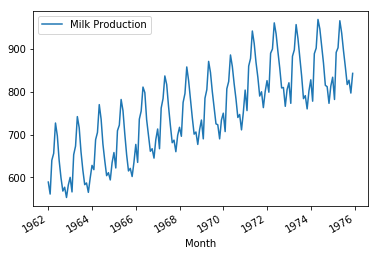

In [5]:
milk.plot()

___

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **

** Create a test train split using indexing (hint: use .head() or tail() or .iloc[]). We don't want a random train test split, we want to specify that the test set is the last 12 months of data is the test set, with everything before it is the training. **

In [6]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [7]:
train = milk.head(156)

In [8]:
test = milk.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!**

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

In [11]:
train_scaled = scaler.fit_transform(train)

In [12]:
test_scaled = scaler.transform(test)

## Batch Function

** We'll need a function that can feed batches of the training data. We'll need to do several things that are listed out as steps in the comments of the function. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions! **

In [13]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    rand_start = np.random.randint(0, len(training_data) - steps)
    
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    y_batch = np.array(training_data[rand_start:rand_start + steps + 1]).reshape(1, steps + 1)
    
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN to .reshape(-1,steps,1)
    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

## Setting Up The RNN Model

** Import TensorFlow **

In [14]:
import tensorflow as tf

### The Constants

** Define the constants in a single cell. You'll need the following (in parenthesis are the values I used in my solution, but you can play with some of these): **
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.03)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [15]:
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
# learning_rate = 0.03 
learning_rate = 0.001
# num_train_iterations = 5000
num_train_iterations = 6000
batch_size = 1

** Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence.**  

In [16]:
x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

** Now create the RNN Layer, you have complete freedom over this, use tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc... Keep in mind not every combination will work well! (If in doubt, the solutions used an Outputprojection Wrapper around a basic LSTM cell with relu activation.**

In [17]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    #tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu), 
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu), 
    output_size=num_outputs)

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [18]:
outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate. **

In [19]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [20]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [21]:
saver = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save your model after you are done training. **

In [22]:
with tf.Session() as s:
    s.run(init)
    
    for iteration in range(num_train_iterations):
        x_batch, y_batch = next_batch(train_scaled, batch_size, num_time_steps)
        s.run(train, feed_dict={x: x_batch, y: y_batch})
        
        if iteration % 100:
            mse = loss.eval(feed_dict={x: x_batch, y: y_batch})
            print(iteration, "\tMSE", mse)
    
    saver.save(s, "./rnn_time_series_model_2")

1 	MSE 0.33265278
2 	MSE 0.11286181
3 	MSE 0.19927867
4 	MSE 0.40195915
5 	MSE 0.44369015
6 	MSE 0.05522291
7 	MSE 0.08386835
8 	MSE 0.088285096
9 	MSE 0.49211624
10 	MSE 0.18003012
11 	MSE 0.039592627
12 	MSE 0.42672828
13 	MSE 0.15225637
14 	MSE 0.3915271
15 	MSE 0.3694582
16 	MSE 0.043310653
17 	MSE 0.16184576
18 	MSE 0.039602373
19 	MSE 0.09591574
20 	MSE 0.02355962
21 	MSE 0.01955936
22 	MSE 0.22886252
23 	MSE 0.02167736
24 	MSE 0.08592387
25 	MSE 0.073488474
26 	MSE 0.03997616
27 	MSE 0.021522423
28 	MSE 0.048102017
29 	MSE 0.1585331
30 	MSE 0.02971232
31 	MSE 0.012547839
32 	MSE 0.106635936
33 	MSE 0.07413834
34 	MSE 0.08323074
35 	MSE 0.04350214
36 	MSE 0.158508
37 	MSE 0.033754304
38 	MSE 0.1095475
39 	MSE 0.013309729
40 	MSE 0.07855094
41 	MSE 0.12161786
42 	MSE 0.082966715
43 	MSE 0.0096471375
44 	MSE 0.16835605
45 	MSE 0.053806473
46 	MSE 0.09405171
47 	MSE 0.023822272
48 	MSE 0.060456857
49 	MSE 0.031901147
50 	MSE 0.060121194
51 	MSE 0.050546024
52 	MSE 0.06640025
53 	MSE

422 	MSE 0.012835443
423 	MSE 0.03237691
424 	MSE 0.01734318
425 	MSE 0.015505503
426 	MSE 0.014279914
427 	MSE 0.006153844
428 	MSE 0.016720777
429 	MSE 0.02455537
430 	MSE 0.016960723
431 	MSE 0.01006643
432 	MSE 0.01725355
433 	MSE 0.010010797
434 	MSE 0.008428432
435 	MSE 0.016659386
436 	MSE 0.017350147
437 	MSE 0.016168438
438 	MSE 0.0067959777
439 	MSE 0.012999657
440 	MSE 0.0121444715
441 	MSE 0.011907942
442 	MSE 0.011312236
443 	MSE 0.011289507
444 	MSE 0.0116861975
445 	MSE 0.014685751
446 	MSE 0.018741487
447 	MSE 0.014174619
448 	MSE 0.01616413
449 	MSE 0.010011858
450 	MSE 0.01427897
451 	MSE 0.014101933
452 	MSE 0.009804732
453 	MSE 0.016887479
454 	MSE 0.017605938
455 	MSE 0.016414149
456 	MSE 0.018374065
457 	MSE 0.013541073
458 	MSE 0.016616037
459 	MSE 0.0139455525
460 	MSE 0.019285556
461 	MSE 0.014152433
462 	MSE 0.021613598
463 	MSE 0.0134905875
464 	MSE 0.012739311
465 	MSE 0.0086897975
466 	MSE 0.016567903
467 	MSE 0.010847301
468 	MSE 0.011543636
469 	MSE 0.014

851 	MSE 0.012845207
852 	MSE 0.005554373
853 	MSE 0.015996039
854 	MSE 0.006342202
855 	MSE 0.009942598
856 	MSE 0.0136598125
857 	MSE 0.012199548
858 	MSE 0.0061859153
859 	MSE 0.006826068
860 	MSE 0.011446421
861 	MSE 0.009038387
862 	MSE 0.017858239
863 	MSE 0.010511901
864 	MSE 0.008629596
865 	MSE 0.011510906
866 	MSE 0.011380777
867 	MSE 0.0061963964
868 	MSE 0.0052956794
869 	MSE 0.008024105
870 	MSE 0.0075850734
871 	MSE 0.008589603
872 	MSE 0.009508316
873 	MSE 0.0077373018
874 	MSE 0.010226351
875 	MSE 0.008552383
876 	MSE 0.014190026
877 	MSE 0.012455243
878 	MSE 0.0119788395
879 	MSE 0.0071594003
880 	MSE 0.009828628
881 	MSE 0.011280648
882 	MSE 0.007675581
883 	MSE 0.011299991
884 	MSE 0.00961106
885 	MSE 0.011861312
886 	MSE 0.009766042
887 	MSE 0.013377797
888 	MSE 0.010942642
889 	MSE 0.012306713
890 	MSE 0.0076561724
891 	MSE 0.00789895
892 	MSE 0.012017916
893 	MSE 0.011622437
894 	MSE 0.009450502
895 	MSE 0.008253682
896 	MSE 0.009607171
897 	MSE 0.0058434852
898 	

1254 	MSE 0.0074304664
1255 	MSE 0.008135806
1256 	MSE 0.0072794817
1257 	MSE 0.006688755
1258 	MSE 0.0103257075
1259 	MSE 0.006000623
1260 	MSE 0.008940545
1261 	MSE 0.005621472
1262 	MSE 0.0074558402
1263 	MSE 0.010430806
1264 	MSE 0.011296694
1265 	MSE 0.005138965
1266 	MSE 0.008614956
1267 	MSE 0.010868933
1268 	MSE 0.008865538
1269 	MSE 0.008613135
1270 	MSE 0.007930611
1271 	MSE 0.0062820115
1272 	MSE 0.008941442
1273 	MSE 0.0064333417
1274 	MSE 0.008259036
1275 	MSE 0.006830383
1276 	MSE 0.008740545
1277 	MSE 0.0060657677
1278 	MSE 0.0062693697
1279 	MSE 0.007339435
1280 	MSE 0.008110751
1281 	MSE 0.008462249
1282 	MSE 0.007210229
1283 	MSE 0.006692659
1284 	MSE 0.013888831
1285 	MSE 0.007428901
1286 	MSE 0.006794123
1287 	MSE 0.008923884
1288 	MSE 0.0075714462
1289 	MSE 0.007767005
1290 	MSE 0.009600543
1291 	MSE 0.007040946
1292 	MSE 0.008967295
1293 	MSE 0.007312428
1294 	MSE 0.007243427
1295 	MSE 0.008756782
1296 	MSE 0.008970186
1297 	MSE 0.008605595
1298 	MSE 0.007985956
1

1656 	MSE 0.007887474
1657 	MSE 0.010914859
1658 	MSE 0.013030924
1659 	MSE 0.0048533957
1660 	MSE 0.0060639274
1661 	MSE 0.005322896
1662 	MSE 0.0064741876
1663 	MSE 0.007346816
1664 	MSE 0.0054855472
1665 	MSE 0.007828768
1666 	MSE 0.0057036146
1667 	MSE 0.0078338785
1668 	MSE 0.007734231
1669 	MSE 0.007296989
1670 	MSE 0.006906636
1671 	MSE 0.0059499233
1672 	MSE 0.006628311
1673 	MSE 0.009405442
1674 	MSE 0.007874731
1675 	MSE 0.007200531
1676 	MSE 0.00707089
1677 	MSE 0.0054664793
1678 	MSE 0.0056178276
1679 	MSE 0.007207846
1680 	MSE 0.0071414164
1681 	MSE 0.008386242
1682 	MSE 0.012903973
1683 	MSE 0.0078110956
1684 	MSE 0.005599922
1685 	MSE 0.008813273
1686 	MSE 0.005358985
1687 	MSE 0.0077730133
1688 	MSE 0.006847249
1689 	MSE 0.005942349
1690 	MSE 0.007975033
1691 	MSE 0.0060232007
1692 	MSE 0.007102627
1693 	MSE 0.009701249
1694 	MSE 0.00580979
1695 	MSE 0.009760956
1696 	MSE 0.005614219
1697 	MSE 0.005834634
1698 	MSE 0.0096584875
1699 	MSE 0.0057563526
1701 	MSE 0.0068729

2056 	MSE 0.0061568394
2057 	MSE 0.0057957475
2058 	MSE 0.006848242
2059 	MSE 0.0040470045
2060 	MSE 0.0042547556
2061 	MSE 0.00905835
2062 	MSE 0.005516414
2063 	MSE 0.0031469632
2064 	MSE 0.0046624043
2065 	MSE 0.009060045
2066 	MSE 0.003645927
2067 	MSE 0.007530466
2068 	MSE 0.009419565
2069 	MSE 0.005794492
2070 	MSE 0.003721755
2071 	MSE 0.004208826
2072 	MSE 0.00451629
2073 	MSE 0.007945686
2074 	MSE 0.004745317
2075 	MSE 0.006135005
2076 	MSE 0.0060089044
2077 	MSE 0.007443322
2078 	MSE 0.010189445
2079 	MSE 0.007816113
2080 	MSE 0.0046134195
2081 	MSE 0.009824056
2082 	MSE 0.010265924
2083 	MSE 0.0032784764
2084 	MSE 0.0032926246
2085 	MSE 0.0051343776
2086 	MSE 0.0052440744
2087 	MSE 0.008285305
2088 	MSE 0.009471067
2089 	MSE 0.006669691
2090 	MSE 0.0063041016
2091 	MSE 0.0071082353
2092 	MSE 0.0066114957
2093 	MSE 0.007126933
2094 	MSE 0.005943032
2095 	MSE 0.0053796433
2096 	MSE 0.0039110226
2097 	MSE 0.0059154574
2098 	MSE 0.0031097897
2099 	MSE 0.004914862
2101 	MSE 0.005

2454 	MSE 0.0027652176
2455 	MSE 0.0063939076
2456 	MSE 0.005549973
2457 	MSE 0.0028383452
2458 	MSE 0.006544238
2459 	MSE 0.006541557
2460 	MSE 0.0046952637
2461 	MSE 0.0042360006
2462 	MSE 0.0030963141
2463 	MSE 0.0023266675
2464 	MSE 0.0050884304
2465 	MSE 0.00471994
2466 	MSE 0.0032385688
2467 	MSE 0.007591581
2468 	MSE 0.003816645
2469 	MSE 0.0076189
2470 	MSE 0.004950338
2471 	MSE 0.010139881
2472 	MSE 0.0060911863
2473 	MSE 0.00735933
2474 	MSE 0.010346724
2475 	MSE 0.0052689235
2476 	MSE 0.004547521
2477 	MSE 0.0058846585
2478 	MSE 0.0075333253
2479 	MSE 0.0022329383
2480 	MSE 0.0071585956
2481 	MSE 0.005117997
2482 	MSE 0.0034884561
2483 	MSE 0.0064663296
2484 	MSE 0.0049570557
2485 	MSE 0.0063768397
2486 	MSE 0.0077956184
2487 	MSE 0.0039861794
2488 	MSE 0.0072870613
2489 	MSE 0.0043989643
2490 	MSE 0.009174674
2491 	MSE 0.007320653
2492 	MSE 0.00904322
2493 	MSE 0.00619174
2494 	MSE 0.0046135266
2495 	MSE 0.006383397
2496 	MSE 0.0041991244
2497 	MSE 0.0055159847
2498 	MSE 0.

2847 	MSE 0.0032125693
2848 	MSE 0.0044475743
2849 	MSE 0.0048346417
2850 	MSE 0.0030260545
2851 	MSE 0.0038138318
2852 	MSE 0.0037853213
2853 	MSE 0.0051886574
2854 	MSE 0.008319883
2855 	MSE 0.011589733
2856 	MSE 0.0043573165
2857 	MSE 0.004843826
2858 	MSE 0.0037092052
2859 	MSE 0.002770664
2860 	MSE 0.0067215064
2861 	MSE 0.003455137
2862 	MSE 0.004031328
2863 	MSE 0.004533795
2864 	MSE 0.0046156626
2865 	MSE 0.0042022266
2866 	MSE 0.0075502372
2867 	MSE 0.0041939933
2868 	MSE 0.0028504205
2869 	MSE 0.010387785
2870 	MSE 0.0062701986
2871 	MSE 0.0055684955
2872 	MSE 0.0059133717
2873 	MSE 0.0073138145
2874 	MSE 0.009086669
2875 	MSE 0.005300494
2876 	MSE 0.0058419663
2877 	MSE 0.004159592
2878 	MSE 0.004882104
2879 	MSE 0.0050693844
2880 	MSE 0.010386341
2881 	MSE 0.0040697553
2882 	MSE 0.0039410074
2883 	MSE 0.0057567116
2884 	MSE 0.004128467
2885 	MSE 0.004273677
2886 	MSE 0.0039962563
2887 	MSE 0.007702635
2888 	MSE 0.005388197
2889 	MSE 0.003945219
2890 	MSE 0.003556891
2891 	M

3231 	MSE 0.0058490206
3232 	MSE 0.0019375808
3233 	MSE 0.006067255
3234 	MSE 0.0065588574
3235 	MSE 0.0040315897
3236 	MSE 0.0023379028
3237 	MSE 0.0056305863
3238 	MSE 0.0091539
3239 	MSE 0.009088748
3240 	MSE 0.0062937085
3241 	MSE 0.0033461768
3242 	MSE 0.00867768
3243 	MSE 0.0039565004
3244 	MSE 0.009180834
3245 	MSE 0.003161056
3246 	MSE 0.006056417
3247 	MSE 0.0065618306
3248 	MSE 0.00628012
3249 	MSE 0.0072944784
3250 	MSE 0.0034546664
3251 	MSE 0.0035450694
3252 	MSE 0.0029253953
3253 	MSE 0.004800518
3254 	MSE 0.008538414
3255 	MSE 0.004387519
3256 	MSE 0.0060505886
3257 	MSE 0.0032568488
3258 	MSE 0.004724437
3259 	MSE 0.0069379187
3260 	MSE 0.0030199431
3261 	MSE 0.007384487
3262 	MSE 0.0071896203
3263 	MSE 0.0034046052
3264 	MSE 0.0089259595
3265 	MSE 0.0072029815
3266 	MSE 0.006598135
3267 	MSE 0.0031681939
3268 	MSE 0.008583006
3269 	MSE 0.004519744
3270 	MSE 0.0048478115
3271 	MSE 0.006587062
3272 	MSE 0.0033102555
3273 	MSE 0.010709763
3274 	MSE 0.0043206695
3275 	MSE 

3606 	MSE 0.0047529694
3607 	MSE 0.0038994781
3608 	MSE 0.0045536687
3609 	MSE 0.0037160653
3610 	MSE 0.01059233
3611 	MSE 0.0058290907
3612 	MSE 0.0035150435
3613 	MSE 0.008656993
3614 	MSE 0.0018975824
3615 	MSE 0.0029715698
3616 	MSE 0.008353648
3617 	MSE 0.001963312
3618 	MSE 0.0032432156
3619 	MSE 0.0054594544
3620 	MSE 0.0035990214
3621 	MSE 0.0041607497
3622 	MSE 0.004808909
3623 	MSE 0.009709174
3624 	MSE 0.0033588307
3625 	MSE 0.0063050855
3626 	MSE 0.009159756
3627 	MSE 0.0043782215
3628 	MSE 0.004937939
3629 	MSE 0.0060857534
3630 	MSE 0.0053075184
3631 	MSE 0.004978379
3632 	MSE 0.0043710005
3633 	MSE 0.0051289634
3634 	MSE 0.0070663705
3635 	MSE 0.003292378
3636 	MSE 0.0065991767
3637 	MSE 0.0033610652
3638 	MSE 0.005552581
3639 	MSE 0.006146305
3640 	MSE 0.003021294
3641 	MSE 0.0057566185
3642 	MSE 0.0045258743
3643 	MSE 0.002839579
3644 	MSE 0.0046786997
3645 	MSE 0.0061599337
3646 	MSE 0.0038835676
3647 	MSE 0.008770504
3648 	MSE 0.0063291737
3649 	MSE 0.0061619855
3650

4001 	MSE 0.00260017
4002 	MSE 0.0019156953
4003 	MSE 0.005814573
4004 	MSE 0.008400122
4005 	MSE 0.0057715434
4006 	MSE 0.0026892137
4007 	MSE 0.0069049746
4008 	MSE 0.0050632064
4009 	MSE 0.005627154
4010 	MSE 0.010736457
4011 	MSE 0.0035876483
4012 	MSE 0.0050843144
4013 	MSE 0.00445636
4014 	MSE 0.0027668292
4015 	MSE 0.003488166
4016 	MSE 0.005000647
4017 	MSE 0.009959171
4018 	MSE 0.004624751
4019 	MSE 0.004008923
4020 	MSE 0.0033360969
4021 	MSE 0.0049737585
4022 	MSE 0.003972462
4023 	MSE 0.006306857
4024 	MSE 0.0104188025
4025 	MSE 0.002803
4026 	MSE 0.0020001486
4027 	MSE 0.007551301
4028 	MSE 0.0050457083
4029 	MSE 0.00496284
4030 	MSE 0.0029975104
4031 	MSE 0.0052353367
4032 	MSE 0.0043334435
4033 	MSE 0.0055971295
4034 	MSE 0.007636461
4035 	MSE 0.0042130887
4036 	MSE 0.0067306994
4037 	MSE 0.0039306707
4038 	MSE 0.0025692612
4039 	MSE 0.008207661
4040 	MSE 0.009661758
4041 	MSE 0.0030127894
4042 	MSE 0.0049639284
4043 	MSE 0.0033350408
4044 	MSE 0.0026086895
4045 	MSE 0.0

4399 	MSE 0.010314963
4401 	MSE 0.0030426718
4402 	MSE 0.0065808
4403 	MSE 0.0045830184
4404 	MSE 0.0036089171
4405 	MSE 0.0026003206
4406 	MSE 0.007770259
4407 	MSE 0.0012206056
4408 	MSE 0.0046076877
4409 	MSE 0.006214659
4410 	MSE 0.005181069
4411 	MSE 0.0034957908
4412 	MSE 0.006569994
4413 	MSE 0.0043467837
4414 	MSE 0.003377938
4415 	MSE 0.0046276147
4416 	MSE 0.003697277
4417 	MSE 0.004321258
4418 	MSE 0.0048558135
4419 	MSE 0.0034780058
4420 	MSE 0.0084335515
4421 	MSE 0.004180337
4422 	MSE 0.003346537
4423 	MSE 0.0025978468
4424 	MSE 0.008042658
4425 	MSE 0.0058060666
4426 	MSE 0.005665516
4427 	MSE 0.0038588282
4428 	MSE 0.005103089
4429 	MSE 0.0042376206
4430 	MSE 0.005182164
4431 	MSE 0.008499192
4432 	MSE 0.002500274
4433 	MSE 0.0025785733
4434 	MSE 0.0059163184
4435 	MSE 0.005902152
4436 	MSE 0.0025327096
4437 	MSE 0.008460824
4438 	MSE 0.006525746
4439 	MSE 0.005541288
4440 	MSE 0.0033935343
4441 	MSE 0.0034714073
4442 	MSE 0.003973439
4443 	MSE 0.0023982709
4444 	MSE 0.

4767 	MSE 0.00067247084
4768 	MSE 0.0024703026
4769 	MSE 0.008539486
4770 	MSE 0.004825097
4771 	MSE 0.0033124608
4772 	MSE 0.006042145
4773 	MSE 0.0054697376
4774 	MSE 0.0047857803
4775 	MSE 0.0077158734
4776 	MSE 0.0063387766
4777 	MSE 0.0044971933
4778 	MSE 0.0064556333
4779 	MSE 0.007143455
4780 	MSE 0.0034699796
4781 	MSE 0.003390033
4782 	MSE 0.0034748716
4783 	MSE 0.0035238499
4784 	MSE 0.003298646
4785 	MSE 0.0043996554
4786 	MSE 0.0040399106
4787 	MSE 0.003807979
4788 	MSE 0.0031102814
4789 	MSE 0.005944995
4790 	MSE 0.0036618344
4791 	MSE 0.0022482781
4792 	MSE 0.004019275
4793 	MSE 0.0059281695
4794 	MSE 0.0028099818
4795 	MSE 0.0044815787
4796 	MSE 0.0035868653
4797 	MSE 0.0034717023
4798 	MSE 0.0026900067
4799 	MSE 0.007256388
4801 	MSE 0.002552105
4802 	MSE 0.0045496156
4803 	MSE 0.005826387
4804 	MSE 0.00347587
4805 	MSE 0.0021857673
4806 	MSE 0.011953504
4807 	MSE 0.0048687444
4808 	MSE 0.0029979993
4809 	MSE 0.0030885234
4810 	MSE 0.0033532118
4811 	MSE 0.0050477204
48

5167 	MSE 0.0025797437
5168 	MSE 0.0060995403
5169 	MSE 0.004849314
5170 	MSE 0.0030708583
5171 	MSE 0.0056771045
5172 	MSE 0.0040716925
5173 	MSE 0.005798738
5174 	MSE 0.0024016856
5175 	MSE 0.0043548597
5176 	MSE 0.0011728051
5177 	MSE 0.005920084
5178 	MSE 0.0038376255
5179 	MSE 0.0016085779
5180 	MSE 0.0038458493
5181 	MSE 0.0029605676
5182 	MSE 0.004313379
5183 	MSE 0.003303608
5184 	MSE 0.0044285636
5185 	MSE 0.0097835185
5186 	MSE 0.004904618
5187 	MSE 0.00213879
5188 	MSE 0.0030733133
5189 	MSE 0.0029713844
5190 	MSE 0.0040251105
5191 	MSE 0.004072568
5192 	MSE 0.0029901813
5193 	MSE 0.004472212
5194 	MSE 0.0022906105
5195 	MSE 0.0036579343
5196 	MSE 0.008998388
5197 	MSE 0.006480435
5198 	MSE 0.003695812
5199 	MSE 0.0017450541
5201 	MSE 0.0058334772
5202 	MSE 0.0031238878
5203 	MSE 0.0102175465
5204 	MSE 0.008570983
5205 	MSE 0.0047789686
5206 	MSE 0.0020815278
5207 	MSE 0.0040734294
5208 	MSE 0.0041432236
5209 	MSE 0.0070548044
5210 	MSE 0.003963267
5211 	MSE 0.0036261182
521

5563 	MSE 0.0043318644
5564 	MSE 0.003014689
5565 	MSE 0.003987288
5566 	MSE 0.0061853775
5567 	MSE 0.003022298
5568 	MSE 0.0046574017
5569 	MSE 0.002884891
5570 	MSE 0.00507017
5571 	MSE 0.0058560744
5572 	MSE 0.0033735961
5573 	MSE 0.0034676604
5574 	MSE 0.0059682806
5575 	MSE 0.0040138103
5576 	MSE 0.0043297806
5577 	MSE 0.00250809
5578 	MSE 0.004815831
5579 	MSE 0.0029269278
5580 	MSE 0.004910187
5581 	MSE 0.0029298216
5582 	MSE 0.0023530668
5583 	MSE 0.0035199458
5584 	MSE 0.008724852
5585 	MSE 0.0065011363
5586 	MSE 0.005369218
5587 	MSE 0.007880607
5588 	MSE 0.007318042
5589 	MSE 0.005037563
5590 	MSE 0.005108663
5591 	MSE 0.0035091247
5592 	MSE 0.0069682933
5593 	MSE 0.004011046
5594 	MSE 0.0053375307
5595 	MSE 0.003146382
5596 	MSE 0.004402188
5597 	MSE 0.0028979827
5598 	MSE 0.0041571558
5599 	MSE 0.001344441
5601 	MSE 0.0041218144
5602 	MSE 0.004743986
5603 	MSE 0.006227685
5604 	MSE 0.0005312703
5605 	MSE 0.003185057
5606 	MSE 0.00067960256
5607 	MSE 0.0024395783
5608 	MSE 

5955 	MSE 0.00813287
5956 	MSE 0.0014755359
5957 	MSE 0.0035450833
5958 	MSE 0.0005845573
5959 	MSE 0.006286394
5960 	MSE 0.0038936667
5961 	MSE 0.007840483
5962 	MSE 0.003413386
5963 	MSE 0.007791834
5964 	MSE 0.007576296
5965 	MSE 0.0040981197
5966 	MSE 0.00681483
5967 	MSE 0.0039884835
5968 	MSE 0.004851463
5969 	MSE 0.0042722565
5970 	MSE 0.0010281185
5971 	MSE 0.0035721136
5972 	MSE 0.0043155146
5973 	MSE 0.00542148
5974 	MSE 0.0031796098
5975 	MSE 0.0034558338
5976 	MSE 0.0049338522
5977 	MSE 0.0050162408
5978 	MSE 0.0039925287
5979 	MSE 0.007707124
5980 	MSE 0.0040129786
5981 	MSE 0.0062178075
5982 	MSE 0.0061472207
5983 	MSE 0.0030943833
5984 	MSE 0.00319112
5985 	MSE 0.005578133
5986 	MSE 0.0061246287
5987 	MSE 0.008012346
5988 	MSE 0.0037217026
5989 	MSE 0.005415825
5990 	MSE 0.0056273188
5991 	MSE 0.010875314
5992 	MSE 0.0037608363
5993 	MSE 0.007114949
5994 	MSE 0.0059968964
5995 	MSE 0.0041499804
5996 	MSE 0.0035664102
5997 	MSE 0.004803956
5998 	MSE 0.0047475607
5999 	MSE

______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [23]:
test

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


** Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set! **

# Generative Session
### NOTE: Recall that our model is really only trained to predict 1 time step ahead, asking it to generate 12 steps is a big ask, and technically not what it was trained to do! Think of this more as generating new values based off some previous pattern, rather than trying to directly predict the future. You would need to go back to the original model and train the model to predict 12 time steps ahead to really get a higher accuracy on the test data. (Which has its limits due to the smaller size of our data set)
** Fill out the session code below to generate 12 months of data based off the last 12 months of data from the training set. The hardest part about this is adjusting the arrays with their shapes and sizes. Reference the lecture for hints.**

In [24]:
with tf.Session() as s:
    saver.restore(s, "./rnn_time_series_model_2")
    
    train_seed = list(train_scaled[-12:])
    
    for iteration in range(12):
        x_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = s.run(outputs, feed_dict={x: x_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_2


** Show the result of the predictions. **

In [25]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.68849325,
 0.58486605,
 0.81916994,
 0.87077266,
 1.0156235,
 0.95918024,
 0.8532054,
 0.7439481,
 0.6210331,
 0.6060323,
 0.5541156,
 0.63915455]

** Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [26]:
res = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12, 1))

** Create a new column on the test_set called "Generated" and set it equal to the generated results. You may get a warning about this, feel free to ignore it.**

In [27]:
test['Generated'] = res

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


** View the test_set dataframe. **

In [28]:
test

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,839.413147
1975-02-01 01:00:00,782.0,796.304260
1975-03-01 01:00:00,892.0,893.774719
1975-04-01 01:00:00,903.0,915.241394
1975-05-01 01:00:00,966.0,975.499390
1975-06-01 01:00:00,937.0,952.018982
1975-07-01 01:00:00,896.0,907.933472
1975-08-01 01:00:00,858.0,862.482422
1975-09-01 01:00:00,817.0,811.349731


** Plot out the two columns for comparison. **

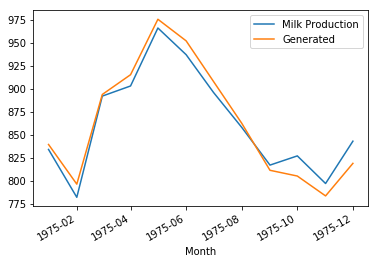

In [29]:
test.plot()

# Great Job!

Play around with the parameters and RNN layers, does a faster learning rate with more steps improve the model? What about GRU or BasicRNN units? What if you train the original model to not just predict one timestep ahead into the future, but 3 instead? Lots of stuff to add on here!